## Model params 1

In [1]:
import yaml
config = "motif_params_2.yaml"
with open(config,'r') as f:
    motif_params = yaml.load(f)

    
print(motif_params)

{'motif_outlier': None, 'out_f': 'processed/2_CHO_GROCap1_GRO1', 'name': 'processed/CHO_GROCap1_GRO1', 'ncomp': 10, 'dim_red': None, 'motif_list': ['tata.motif', 'inr.motif', 'ctcf.motif', 'elf1.motif', 'foxp1.motif', 'e2f.motif', 'hif2a.motif'], 'peak_outlier': 0, 'peak_z_outlier': True, 'cluster_alg': 'hdb', 'class_alg': 'None', 'group_names': ['Promoter', 'Enhancer'], 'group_files': ['processed/sample_CHO_GROCap1_and_CHO_GRO1.tsv', 'processed/enhancer_CHO_GROCap1_and_CHO_GRO1'], 'norm': 'Binary'}


## Import libraries

In [9]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'

import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]
mRNA_peak_150_file = doc["mRNA_peak_150_file"]
supplemental = doc["supplemental"]
tss_annotation = doc['tss_annotation']
import annotation
import os
os.chdir
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
import time

from os.path import basename
from Homer import *
from create_output import *
print('Number of tissues: ',len(tissues))
import plot_tss_results
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
('Number of tissues: ', 13)


In [3]:
import motif_analysis

# A. Methods

## Load files

In [4]:
anno_df = pd.read_csv(motif_params["name"] + ".anno" ,sep="\t",index_col=0)
anno_df.head()

,Chr,Start,End,Strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,p-value vs Control,Fold Change vs Local,p-value vs Local,Dispersion Ratio,Periodic Ratio,Nearest TSS,Distance to TSS,isSameStrand
#PeakID,,,,,,,,,,,,,,,,,,
NW_020822465.1-1,NW_020822465.1,12601780,12601930,+,3959.2,0.920,105445.0,82497.3,8891.0,9.28,0.0,9985.41,0.0,0.860768,0.510682,NM_001246742.1,-24672.0,False
NW_020822391.1-1,NW_020822391.1,705573,705723,+,887.1,0.891,23648.0,18485.0,7306.0,2.53,0.0,2692.68,0.0,0.859391,0.392157,XM_027389096.1,-326.0,False
NW_020822519.1-1,NW_020822519.1,30535313,30535463,+,821.9,0.886,22669.0,17125.6,5189.0,3.30,0.0,335.22,0.0,0.919301,0.543109,XM_027411336.1,-18627.0,False
NW_020822618.1-1,NW_020822618.1,4328685,4328835,-,737.3,0.991,19598.0,15363.1,4836.0,3.18,0.0,6598.99,0.0,0.996479,0.275362,XM_027428396.1,21529.0,True
NW_020822465.1-2,NW_020822465.1,12627307,12627457,+,639.4,0.929,17120.0,13324.0,2049.0,6.50,0.0,763.86,0.0,0.896852,0.575585,NM_001246742.1,-50199.0,False


In [5]:
peak_by_motif = pd.read_csv(motif_params["name"] + ".motifCount" ,sep="\t",index_col=0)
peak_by_motif.head()

,ap1.motif,ap2.motif,ap2gamma.motif,ap4.motif,ar-half.motif,are-fox.motif,are.motif,arnt.motif,ascl1.motif,atf1.motif,...,znf467.motif,znf519.motif,znf528.motif,znf652.motif,znf669.motif,znf675.motif,znf692.motif,znf7.motif,znf711.motif,zscan22.motif
#PeakID,,,,,,,,,,,,,,,,,,,,,
NW_020822465.1-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822391.1-1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822519.1-1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NW_020822618.1-1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,3
NW_020822465.1-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. Normalize data

In [6]:
peak_by_motif = motif_analysis.norm_data(peak_by_motif,motif_params["norm"])
peak_by_motif.head()

,ap1.motif,ap2.motif,ap2gamma.motif,ap4.motif,ar-half.motif,are-fox.motif,are.motif,arnt.motif,ascl1.motif,atf1.motif,...,znf467.motif,znf519.motif,znf528.motif,znf652.motif,znf669.motif,znf675.motif,znf692.motif,znf7.motif,znf711.motif,zscan22.motif
#PeakID,,,,,,,,,,,,,,,,,,,,,
NW_020822465.1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NW_020822391.1-1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
NW_020822519.1-1,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NW_020822618.1-1,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,True,False,False,True
NW_020822465.1-2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 2. Peak outlier Detection

In [7]:
anno_df, peak_by_motif = motif_analysis.peak_outlier(anno_df,peak_by_motif,count_col = "Normalized Tag Count", 
                            outlier = motif_params["peak_outlier"],z_outlier = motif_params["peak_z_outlier"])
                                      

('Number of peaks before: ', 73440)
('Number of peaks before: ', 72485)


## 3. Motif Outlier Detection

## 4. Motifs List/Dimensionalty Reduction

In [10]:
motif_params["motif_list"]

['tata.motif',
 'inr.motif',
 'ctcf.motif',
 'elf1.motif',
 'foxp1.motif',
 'e2f.motif',
 'hif2a.motif']

In [12]:
peak_by_motif = motif_analysis.reduce_list(
    peak_by_motif,
    dim_red=motif_params["dim_red"],
    ncomp=motif_params["ncomp"],
    motif_list=motif_params["motif_list"],save_f=motif_params["out_f"])



In [13]:
peak_by_motif.head()

,ctcf.motif,e2f.motif,elf1.motif,foxp1.motif,hif2a.motif,inr.motif,tata.motif
#PeakID,,,,,,,
NW_020822570.1-14,False,False,False,False,False,False,False
NW_020822406.1-10,False,False,False,False,False,False,False
NW_020822604.1-10,False,False,True,False,False,False,False
NW_020822457.1-3,False,False,False,False,False,False,False
NW_020822461.1-16,True,False,False,False,False,False,False


## 5. Use peak set

In [14]:
peak_by_motif,anno_df = motif_analysis.peak_set(peak_by_motif,anno_df, "processed/groups")

/data/isshamie/TSS/Analysis/src/motif_analysis.py:496: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  anno_df["Cluster_Label"] = pd.Series(groups)
/data/isshamie/TSS/Analysis/src/motif_analysis.py:498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: label_inds[x])


In [15]:
print(peak_by_motif.shape)
print(anno_df.shape)

(12205, 7)
(12205, 22)


## 6. Clustering/Classification

### Cluster with new axes

In [16]:
import hdbscan

In [17]:
%%time
clusterer = hdbscan.HDBSCAN()
clusterer.fit(peak_by_motif)


CPU times: user 4.19 s, sys: 184 ms, total: 4.37 s
Wall time: 1.78 s


In [18]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [19]:
anno_df["HD Clusters"] = clusterer.labels_
anno_df

,Chr,Start,End,Strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,...,Dispersion Ratio,Periodic Ratio,Nearest TSS,Distance to TSS,isSameStrand,Z,Outlier,Cluster_Label,Cluster,HD Clusters
#PeakID,,,,,,,,,,,,,,,,,,,,,
NW_020822570.1-14,NW_020822570.1,14938105,14938255,+,88.200,0.591,2348.0,1838.5,391.0,4.70,...,0.396243,0.446959,XM_027418448.1,18.0,True,2.998378,False,Promoter,1,20
NW_020822461.1-16,NW_020822461.1,20414210,20414360,-,88.100,0.938,2348.0,1836.1,543.0,3.38,...,0.952178,0.357143,XM_027401490.1,15.0,True,2.994559,False,Promoter,1,26
NW_020822487.1-11,NW_020822487.1,18561919,18562069,+,88.000,0.903,2349.0,1834.5,799.0,2.30,...,0.355925,0.437459,XM_027405739.1,59.0,True,2.990739,False,Promoter,1,20
NW_020822375.1-10,NW_020822375.1,27039731,27039881,+,87.900,0.605,2339.0,1831.4,313.0,5.85,...,0.182363,0.606283,XM_027388086.1,49.0,True,2.986919,False,Promoter,1,1
NW_020822604.1-11,NW_020822604.1,9596504,9596654,+,87.900,0.953,2336.0,1830.6,395.0,4.63,...,0.423555,0.694651,XM_027423899.1,45.0,True,2.986919,False,Promoter,1,5
NW_020822375.1-11,NW_020822375.1,4293900,4294050,-,87.800,0.616,2336.0,1829.8,291.0,6.29,...,0.653631,0.669975,XM_027387786.1,20.0,True,2.983099,False,Promoter,1,5
NW_020822506.1-7,NW_020822506.1,10185794,10185944,+,87.500,0.943,2326.0,1822.8,323.0,5.64,...,0.884731,0.514925,XM_027409516.1,11.0,True,2.971640,False,Promoter,1,20
NW_020822375.1-12,NW_020822375.1,13669882,13670032,+,87.400,0.901,2324.0,1821.2,601.0,3.03,...,0.577653,0.482125,XM_027387725.1,117.0,True,2.967820,False,Promoter,1,20
NW_020822461.1-15,NW_020822461.1,39791903,39792053,+,87.400,0.770,2364.0,1821.2,95.0,19.17,...,0.663314,0.644156,XM_027401767.1,81.0,True,2.967820,False,Promoter,1,5


In [20]:
anno_df.groupby("HD Clusters").size()

HD Clusters
-1       42
 0        8
 1       21
 2       55
 3       25
 4      102
 5     1443
 6       19
 7       68
 8        7
 9       18
 10     183
 11      18
 12      56
 13     113
 14      13
 15      20
 16      12
 17     483
 18      12
 19     355
 20    7402
 21     162
 22       6
 23     234
 24      25
 25      20
 26    1283
dtype: int64

In [21]:
anno_df[anno_df["HD Clusters"].isin([0,1])]

,Chr,Start,End,Strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,...,Dispersion Ratio,Periodic Ratio,Nearest TSS,Distance to TSS,isSameStrand,Z,Outlier,Cluster_Label,Cluster,HD Clusters
#PeakID,,,,,,,,,,,,,,,,,,,,,
NW_020822375.1-10,NW_020822375.1,27039731,27039881,+,87.90,0.605,2339.0,1831.4,313.0,5.85,...,0.182363,0.606283,XM_027388086.1,49.0,True,2.986919,False,Promoter,1,1
NW_020822439.1-47,NW_020822439.1,22721170,22721320,-,80.60,0.638,2145.0,1679.3,376.0,4.47,...,0.553947,0.580105,XM_027396834.1,10.0,True,2.708070,False,Promoter,1,1
NW_020822370.1-30,NW_020822370.1,36537476,36537626,-,68.70,0.764,1826.0,1430.8,593.0,2.41,...,0.670137,0.543189,XM_027387177.1,47.0,True,2.253508,False,Promoter,1,1
NW_020822499.1-22,NW_020822499.1,23366584,23366734,-,59.00,0.777,1602.0,1228.5,143.0,8.59,...,0.451674,0.565668,XM_027406600.1,87.0,True,1.882983,False,Promoter,1,1
NW_020822605.1-13,NW_020822605.1,5445908,5446058,+,52.10,0.773,1386.0,1086.6,353.0,3.08,...,0.470418,0.696185,XM_027423975.1,8.0,True,1.619414,False,Promoter,1,1
NW_020822567.1-84,NW_020822567.1,2819621,2819771,+,51.20,0.883,1361.0,1067.0,252.0,4.23,...,0.789860,0.531469,XM_027417093.1,114994.0,True,1.585035,False,Enhancer,0,1
NW_020822512.1-6,NW_020822512.1,4008427,4008577,-,50.50,0.711,1350.0,1052.1,176.0,5.98,...,0.424739,0.331606,XM_027410513.1,65.0,True,1.558296,False,Promoter,1,1
NW_020822462.1-14,NW_020822462.1,13937054,13937204,-,46.40,0.576,1237.0,966.7,370.0,2.61,...,0.311994,0.275618,XM_027402057.1,12.0,True,1.401682,False,Promoter,1,1
NW_020822373.1-11,NW_020822373.1,3305952,3306102,-,44.90,0.740,1197.0,935.3,347.0,2.70,...,0.718960,0.477612,XM_027387518.1,13.0,True,1.344385,False,Promoter,1,0


In [22]:
peak_by_motif[anno_df["HD Clusters"].isin([0,1])]

,ctcf.motif,e2f.motif,elf1.motif,foxp1.motif,hif2a.motif,inr.motif,tata.motif
#PeakID,,,,,,,
NW_020822375.1-10,False,False,True,False,True,False,False
NW_020822439.1-47,False,False,True,False,True,False,False
NW_020822370.1-30,False,False,True,False,True,False,False
NW_020822499.1-22,False,False,True,False,True,False,False
NW_020822605.1-13,False,False,True,False,True,False,False
NW_020822567.1-84,False,False,True,False,True,False,False
NW_020822512.1-6,False,False,True,False,True,False,False
NW_020822462.1-14,False,False,True,False,True,False,False
NW_020822373.1-11,False,False,False,False,True,True,False


# B. Results

### The first two dimensions of PCA shows a continous separation of peaks. 
Fig A shows a density plot that highlights most of the motifs at around (0,0), but with interesting linear relationships between PCs

In [28]:
peak_by_motif = peak_by_motif.astype(int)

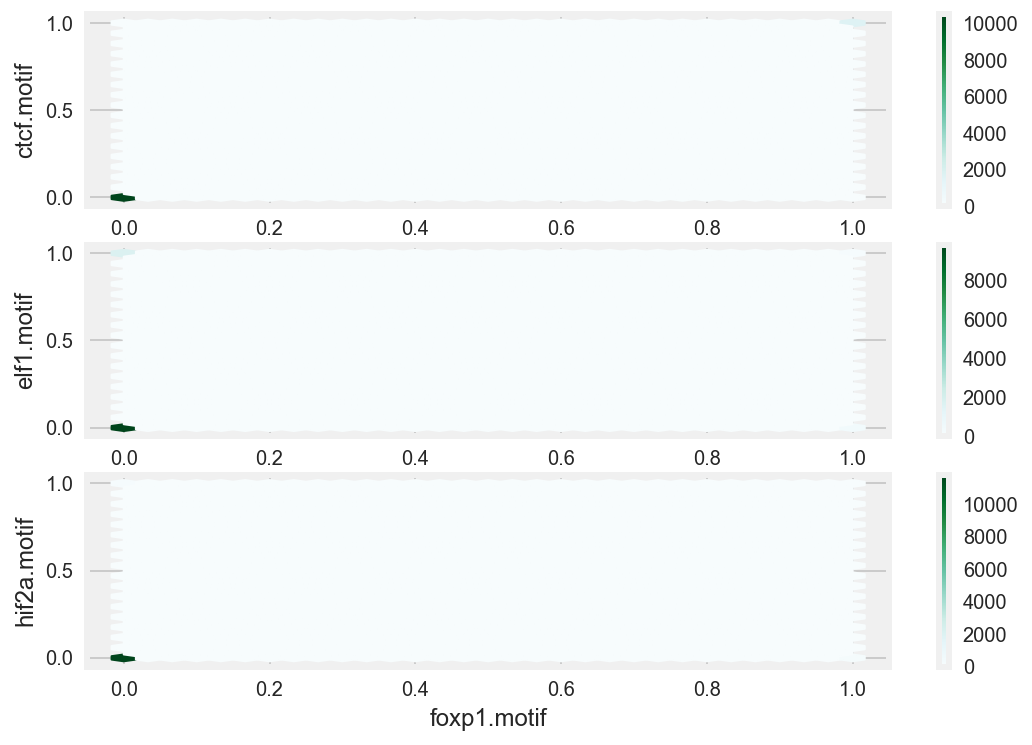

In [33]:
ax = plt.subplot(3,1,1)

peak_by_motif.plot.hexbin(x=0,y=0,gridsize=30,ax = ax)
ax = plt.subplot(3,1,2)
peak_by_motif.plot.hexbin(x=1,y=2,gridsize=30,ax=ax)
ax = plt.subplot(3,1,3)
peak_by_motif.plot.hexbin(x=3,y=4,gridsize=30,ax=ax)

## The peaks in the 'high-PC1' area seemed to be enriched with enhancers (i.e. over 40Kb, with divergent transcription and over 1CPM)  

### Which is highlighted when plotting the distance to TSS

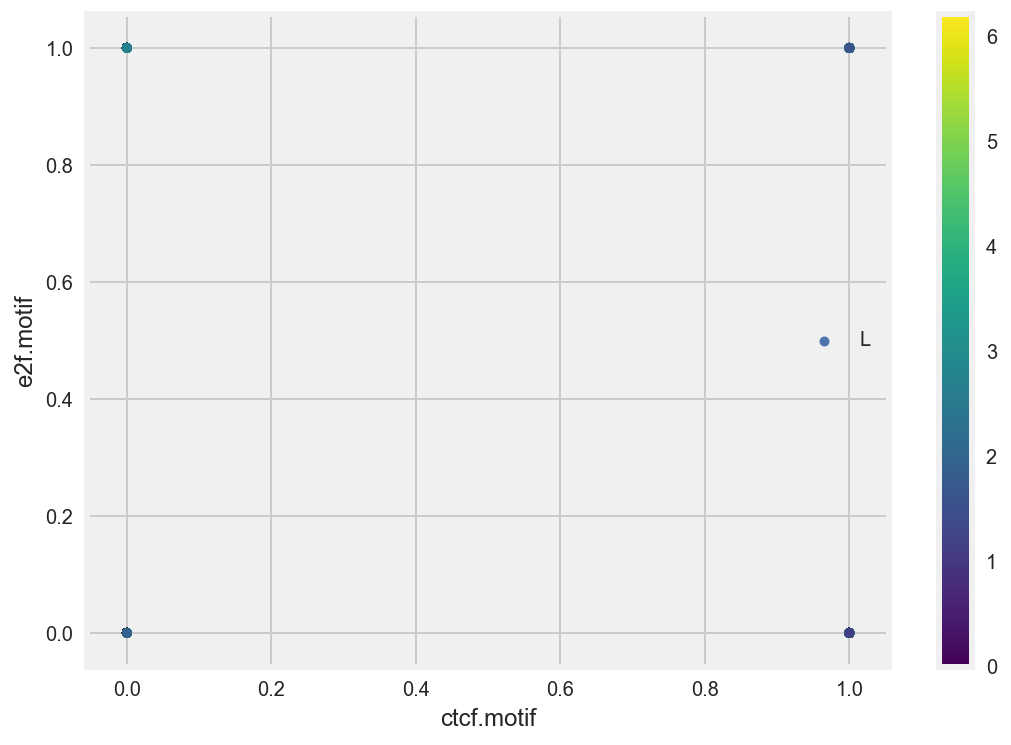

In [36]:
tmp = peak_by_motif.iloc[:,:2].copy()
tmp["Cluster"] = anno_df["Cluster"]

tmp.plot.scatter(x=0,y=1,c=np.log10(np.abs(anno_df["Distance to TSS"])+1),colormap='viridis')
plt.legend("Log Distance to TSS")

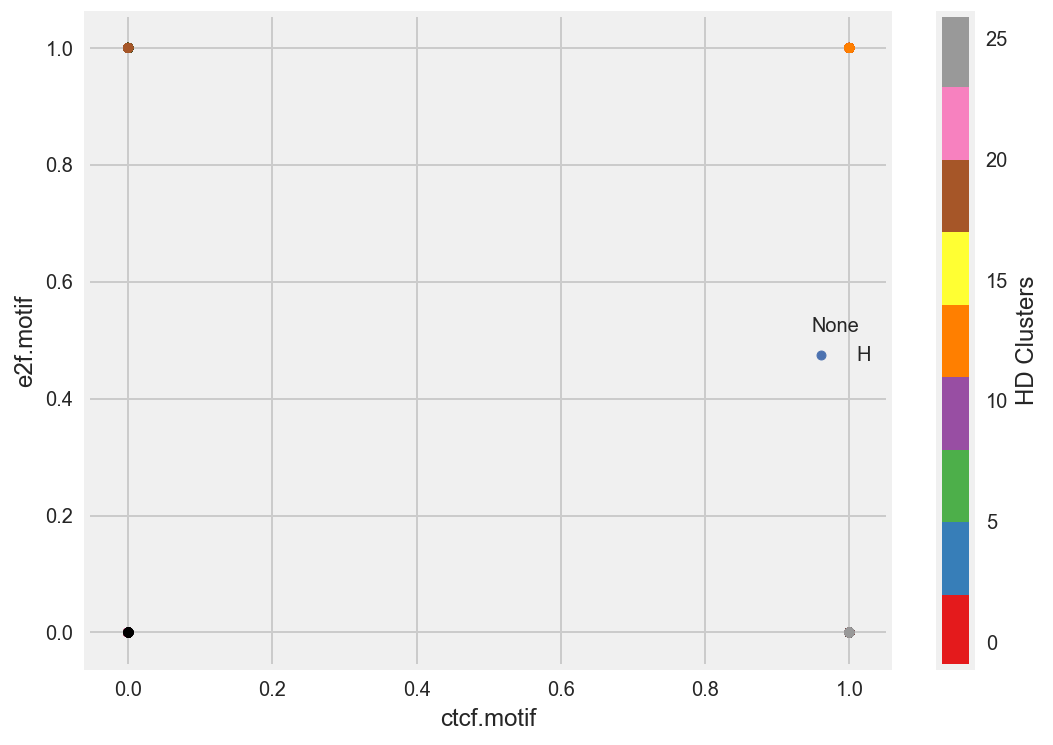

In [37]:
tmp = peak_by_motif.iloc[:,:2].copy()
tmp["HD Clusters"] = anno_df["HD Clusters"]

tmp.plot.scatter(x=0,y=1,c="HD Clusters",colormap='Set1')
plt.legend("HD Clusters")

# Clusters 0 and 1 were found just 11 times
peak_by_motif[anno_df["HD Clusters"].isin([0,1])].plot.scatter(x=0,y=1,ax=plt.gca(),c="Black")

In [40]:
peak_by_motif.groupby("ctcf.motif").count()
#sns.violinplot(x="ctcf.motf",y="tata.motif")

,e2f.motif,elf1.motif,foxp1.motif,hif2a.motif,inr.motif,tata.motif
ctcf.motif,,,,,,
0,10497,10497,10497,10497,10497,10497
1,1708,1708,1708,1708,1708,1708


In [43]:
anno_df.head(100)

,Chr,Start,End,Strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,...,Dispersion Ratio,Periodic Ratio,Nearest TSS,Distance to TSS,isSameStrand,Z,Outlier,Cluster_Label,Cluster,HD Clusters
#PeakID,,,,,,,,,,,,,,,,,,,,,
NW_020822570.1-14,NW_020822570.1,14938105,14938255,+,88.2,0.591,2348.0,1838.5,391.0,4.70,...,0.396243,0.446959,XM_027418448.1,18.0,True,2.998378,False,Promoter,1,20
NW_020822461.1-16,NW_020822461.1,20414210,20414360,-,88.1,0.938,2348.0,1836.1,543.0,3.38,...,0.952178,0.357143,XM_027401490.1,15.0,True,2.994559,False,Promoter,1,26
NW_020822487.1-11,NW_020822487.1,18561919,18562069,+,88.0,0.903,2349.0,1834.5,799.0,2.30,...,0.355925,0.437459,XM_027405739.1,59.0,True,2.990739,False,Promoter,1,20
NW_020822375.1-10,NW_020822375.1,27039731,27039881,+,87.9,0.605,2339.0,1831.4,313.0,5.85,...,0.182363,0.606283,XM_027388086.1,49.0,True,2.986919,False,Promoter,1,1
NW_020822604.1-11,NW_020822604.1,9596504,9596654,+,87.9,0.953,2336.0,1830.6,395.0,4.63,...,0.423555,0.694651,XM_027423899.1,45.0,True,2.986919,False,Promoter,1,5
NW_020822375.1-11,NW_020822375.1,4293900,4294050,-,87.8,0.616,2336.0,1829.8,291.0,6.29,...,0.653631,0.669975,XM_027387786.1,20.0,True,2.983099,False,Promoter,1,5
NW_020822506.1-7,NW_020822506.1,10185794,10185944,+,87.5,0.943,2326.0,1822.8,323.0,5.64,...,0.884731,0.514925,XM_027409516.1,11.0,True,2.971640,False,Promoter,1,20
NW_020822375.1-12,NW_020822375.1,13669882,13670032,+,87.4,0.901,2324.0,1821.2,601.0,3.03,...,0.577653,0.482125,XM_027387725.1,117.0,True,2.967820,False,Promoter,1,20
NW_020822461.1-15,NW_020822461.1,39791903,39792053,+,87.4,0.770,2364.0,1821.2,95.0,19.17,...,0.663314,0.644156,XM_027401767.1,81.0,True,2.967820,False,Promoter,1,5


In [46]:
anno_df["log10 Distance"] = np.log10(np.abs(anno_df["Distance to TSS"])+1)


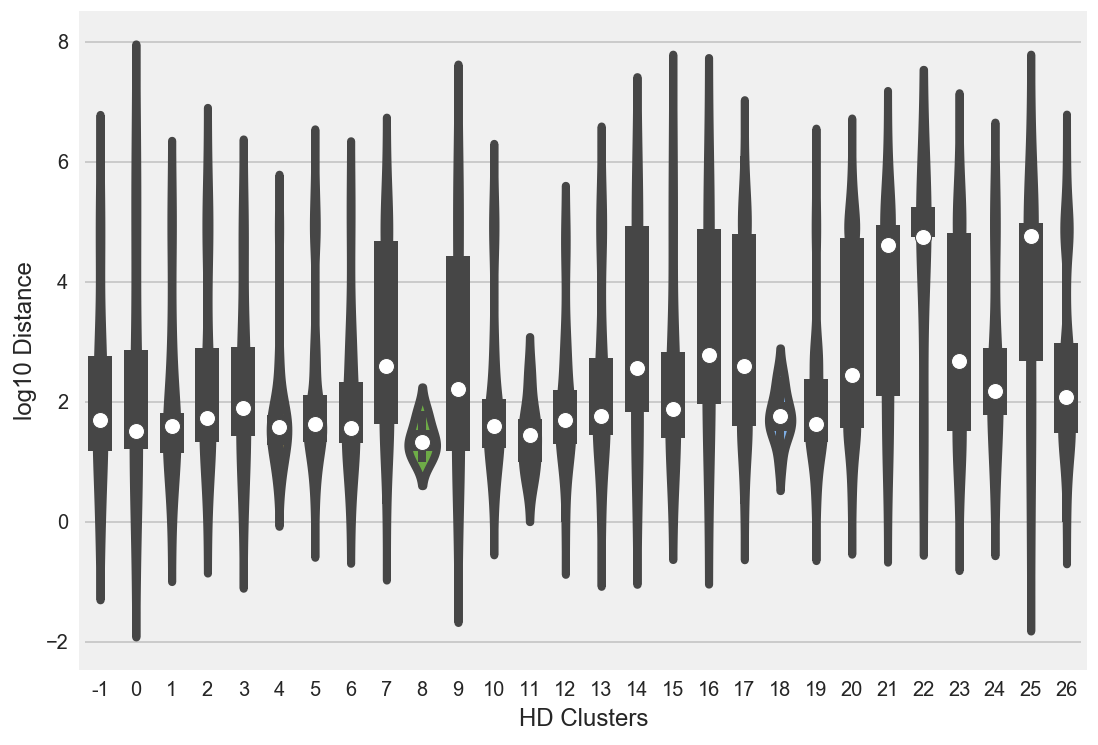

In [49]:
ax = sns.violinplot(x="HD Clusters", y="log10 Distance", data=anno_df)



# C. Discussion